# Exploratory Data Analysis

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import scipy

import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import dates

<IPython.core.display.Javascript object>

## Data Cleaning

In [3]:
pricing_data_df = pd.read_csv("data/test.csv")

<IPython.core.display.Javascript object>

During upfront pricing, the following factors are available to us:

1. Type of vehicle - premium, XL, go, etc
2. Customers Profile
    - Fraud Score
    - Lifetime value
    - Number of previous cancellation by driver within journey
3. Geography
    - Distance
    - Starting destination
    - Ending destination
    - Tolls
2. Traffic
    - Wait time due to incoming traffic
3. Surge
    - Time of day i.e. Rush Hoiur
    - High Demand/Low Supply
    - Bad weather

In [4]:
pricing_data_df["calc_created"] = pd.to_datetime(pricing_data_df["calc_created"])

<IPython.core.display.Javascript object>

* Removing all UIDs and tokens as we can't feed them into model and UUIDs are calculated uniquely for each session.
* Ticket ID for resolution isn't useful as we don't have any ticket information.

In [5]:
pricing_data_df.drop(
    ["driver_device_uid_new", "device_token", "ticket_id_new"], axis=1, inplace=True
)

<IPython.core.display.Javascript object>

Can we remove all the states if all the rides are `finished`?

In [6]:
pricing_data_df["b_state"].value_counts()

finished    4943
Name: b_state, dtype: int64

<IPython.core.display.Javascript object>

In [7]:
pricing_data_df["order_state"].value_counts()

finished    4942
active         1
Name: order_state, dtype: int64

<IPython.core.display.Javascript object>

In [8]:
pricing_data_df["order_try_state"].value_counts()

finished    4943
Name: order_try_state, dtype: int64

<IPython.core.display.Javascript object>

In [9]:
pricing_data_df.drop(
    ["b_state", "order_state", "order_try_state"], axis=1, inplace=True
)

<IPython.core.display.Javascript object>

All the orders are finished, hence this information is redundant.

We can remove `order_try_id_new` since we already have `order_id_new` available. Furthermore, `dest_change_number` let's us know how many times the destination was changed.

In [10]:
pricing_data_df.drop(["order_try_id_new"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [11]:
pricing_data_df.drop_duplicates(inplace=True)

<IPython.core.display.Javascript object>

In [12]:
pricing_data_df.reset_index(inplace=True, drop=True)

<IPython.core.display.Javascript object>

In [13]:
pricing_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4270 entries, 0 to 4269
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   order_id_new           4270 non-null   int64         
 1   calc_created           4270 non-null   datetime64[ns]
 2   metered_price          4251 non-null   float64       
 3   upfront_price          2984 non-null   float64       
 4   distance               4270 non-null   int64         
 5   duration               4270 non-null   int64         
 6   gps_confidence         4270 non-null   int64         
 7   entered_by             4270 non-null   object        
 8   dest_change_number     4270 non-null   int64         
 9   prediction_price_type  4251 non-null   object        
 10  predicted_distance     4251 non-null   float64       
 11  predicted_duration     4251 non-null   float64       
 12  change_reason_pricing  258 non-null    object        
 13  rid

<IPython.core.display.Javascript object>

In [14]:
upfront_pricing_data_df = pricing_data_df.loc[
    (pricing_data_df["upfront_price"].notnull()),
    :,
]

<IPython.core.display.Javascript object>

In [15]:
upfront_pricing_data_df["prediction_price_type"].value_counts()

upfront    2984
Name: prediction_price_type, dtype: int64

<IPython.core.display.Javascript object>

Since all upfront prices have prediction price type as upfront, we can drop `prediction_price_type`,

In [16]:
upfront_pricing_data_df.drop(["prediction_price_type"], axis=1, inplace=True)

/var/folders/s4/n8kktn1x7jn2c6hfpf4y7hch0000gq/T/ipykernel_73208/1004787767.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upfront_pricing_data_df.drop(["prediction_price_type"], axis=1, inplace=True)


<IPython.core.display.Javascript object>

## Problem Scope

Does a deviation actually exist?

In [17]:
upfront_pricing_data_df["upfront_price_deviation_perc"] = (
    (
        upfront_pricing_data_df["upfront_price"]
        - upfront_pricing_data_df["metered_price"]
    )
    / upfront_pricing_data_df["upfront_price"]
    * 100
)
upfront_pricing_data_df["abs_upfront_price_deviation_perc"] = abs(
    upfront_pricing_data_df["upfront_price_deviation_perc"]
)

/var/folders/s4/n8kktn1x7jn2c6hfpf4y7hch0000gq/T/ipykernel_73208/619866292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upfront_pricing_data_df["upfront_price_deviation_perc"] = (
/var/folders/s4/n8kktn1x7jn2c6hfpf4y7hch0000gq/T/ipykernel_73208/619866292.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upfront_pricing_data_df["abs_upfront_price_deviation_perc"] = abs(


<IPython.core.display.Javascript object>

In [18]:
upfront_pricing_data_df["abs_upfront_price_deviation_perc"].describe(
    percentiles=[0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99]
)

count    2984.000000
mean       30.682526
std        58.033973
min         0.000000
25%         4.425441
50%        16.654625
75%        34.251152
85%        51.847166
90%        64.516857
95%        98.778312
99%       263.677587
max      1154.732387
Name: abs_upfront_price_deviation_perc, dtype: float64

<IPython.core.display.Javascript object>

Roughly 50% of the orders are deviating below 20% from the upfront pricing. 

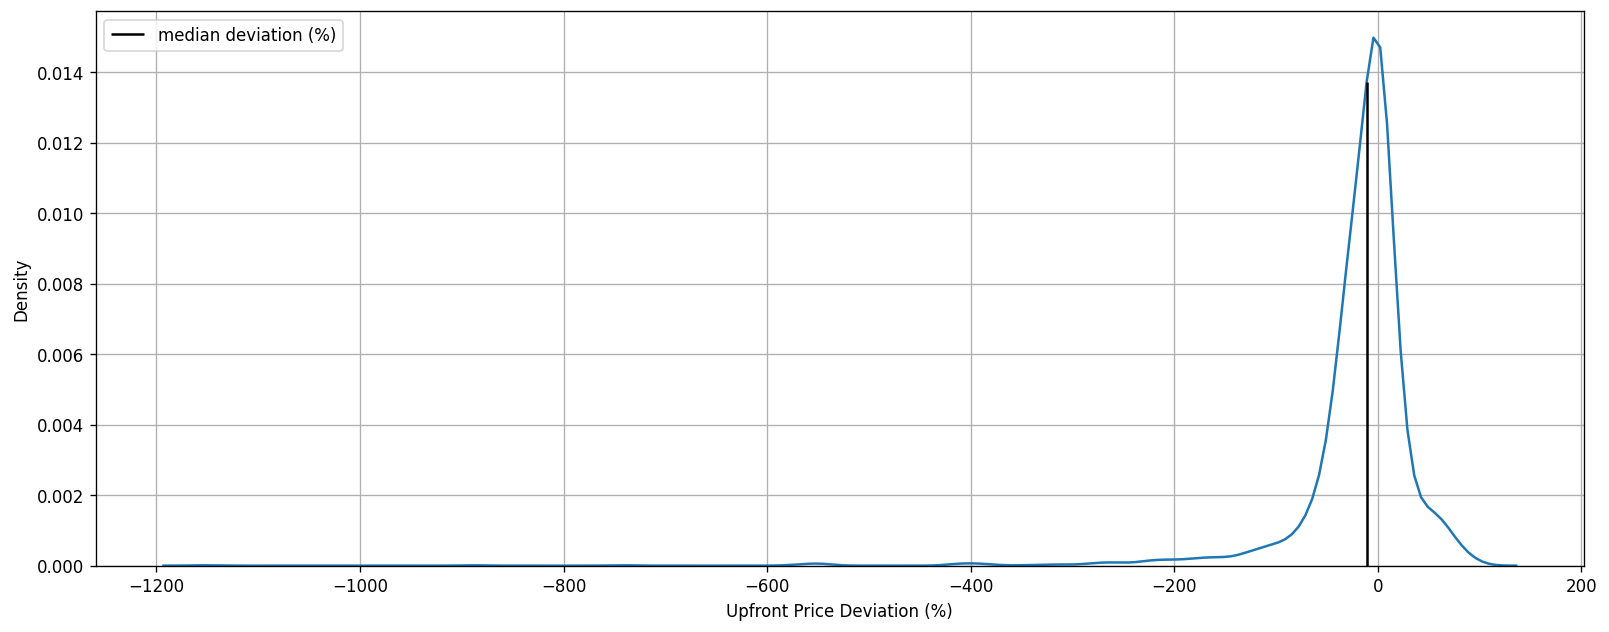

<IPython.core.display.Javascript object>

In [19]:
fig, ax = plt.subplots(figsize=(16, 6), dpi=120)
p = sns.kdeplot(data=upfront_pricing_data_df["upfront_price_deviation_perc"], ax=ax)
x, y = p.get_lines()[0].get_data()
cdf = scipy.integrate.cumtrapz(y, x, initial=0)
nearest_05 = np.abs(cdf - 0.5).argmin()
x_median = x[nearest_05]
y_median = y[nearest_05]
plt.vlines(x_median, 0, y_median, colors="black", label="median deviation (%)")
plt.legend()
plt.xlabel("Upfront Price Deviation (%)")
plt.grid()
plt.show()

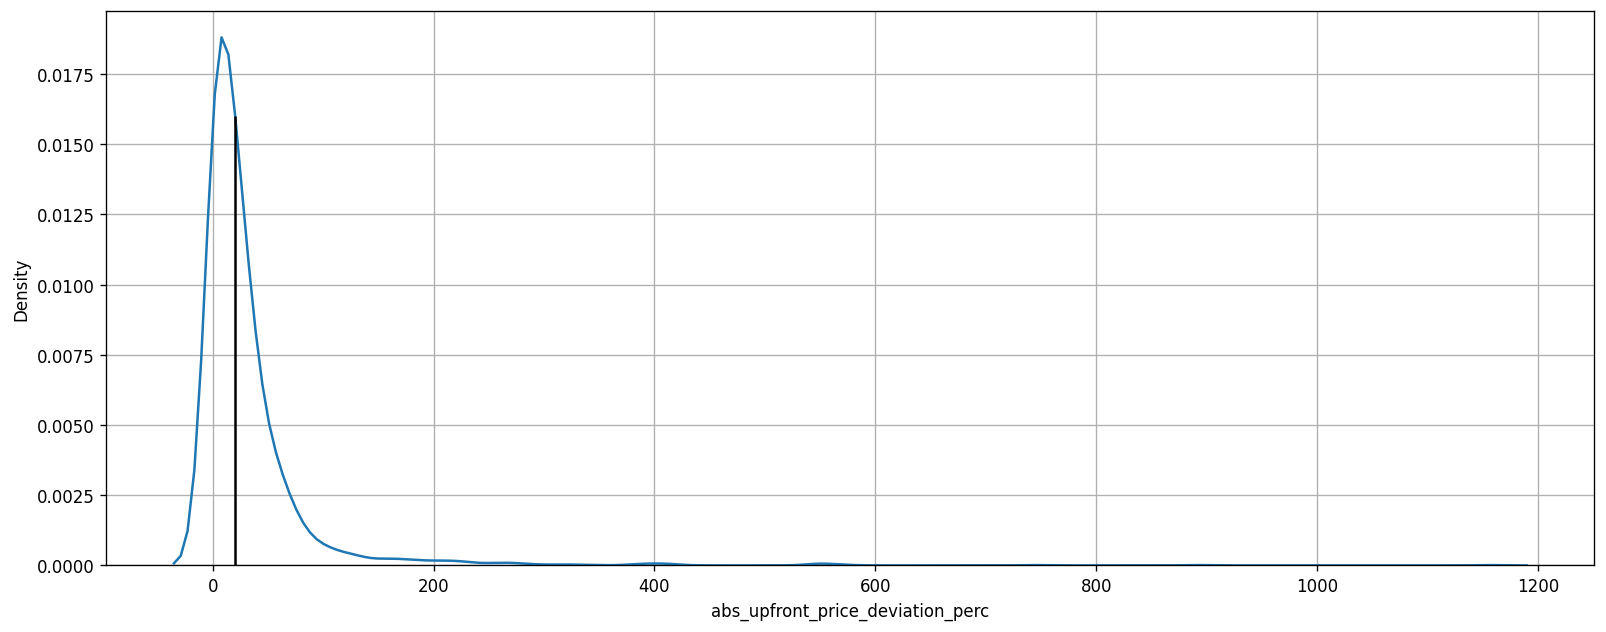

<IPython.core.display.Javascript object>

In [20]:
fig, ax = plt.subplots(figsize=(16, 6), dpi=120)
p = sns.kdeplot(data=upfront_pricing_data_df["abs_upfront_price_deviation_perc"], ax=ax)
x, y = p.get_lines()[0].get_data()
cdf = scipy.integrate.cumtrapz(y, x, initial=0)
nearest_05 = np.abs(cdf - 0.5).argmin()
x_median = x[nearest_05]
y_median = y[nearest_05]
plt.vlines(x_median, 0, y_median, colors="black")
plt.grid()
plt.show()

The distribution of pricing is right skewed long tailed. Our focus will on identifying what the source of the 50% of the error is.

## Predicted vs Actual Values

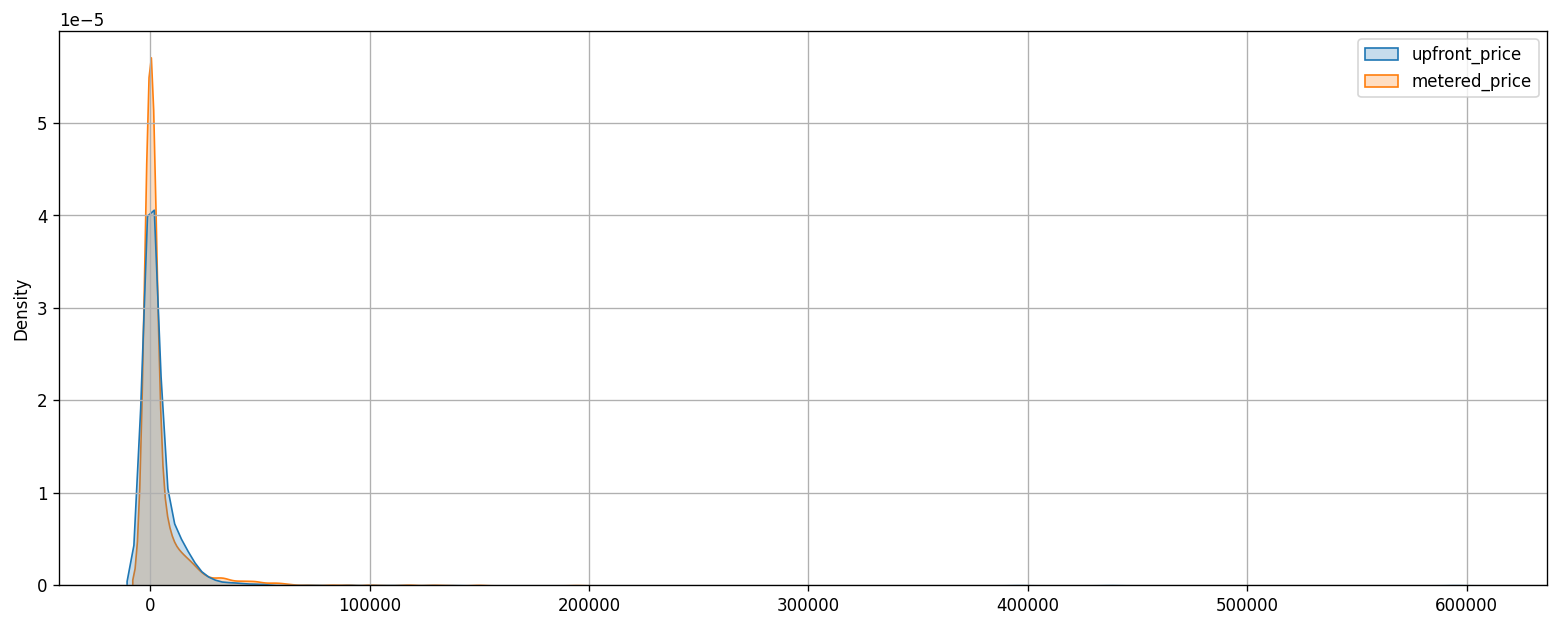

<IPython.core.display.Javascript object>

In [21]:
fig, ax = plt.subplots(figsize=(16, 6), dpi=120)
sns.kdeplot(
    data=upfront_pricing_data_df[["upfront_price", "metered_price"]], ax=ax, fill=True
)
plt.grid()
plt.show()

Upfront pricing typically seems to be a lower than the metered pricing.

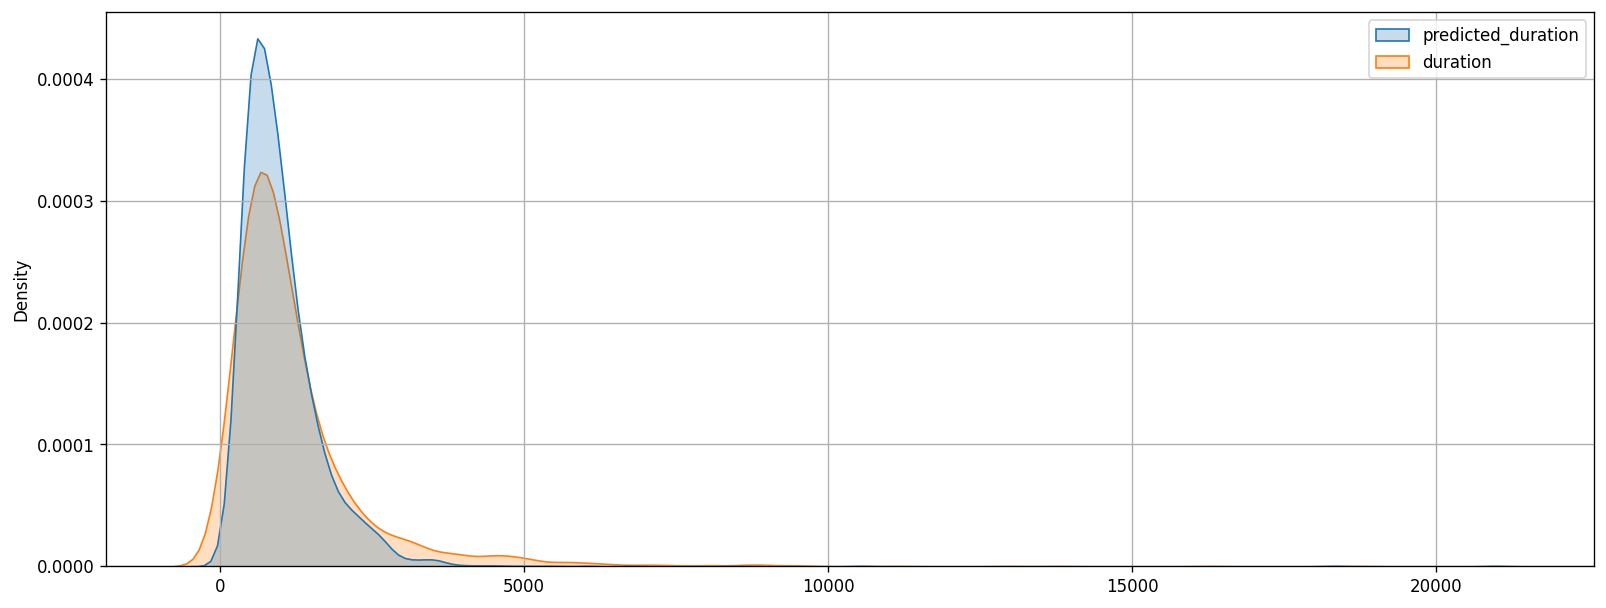

<IPython.core.display.Javascript object>

In [22]:
fig, ax = plt.subplots(figsize=(16, 6), dpi=120)
sns.kdeplot(
    data=upfront_pricing_data_df[["predicted_duration", "duration"]], ax=ax, fill=True
)
plt.grid()
plt.show()

That's because predicted duration seems to be lesser than the actual duration.

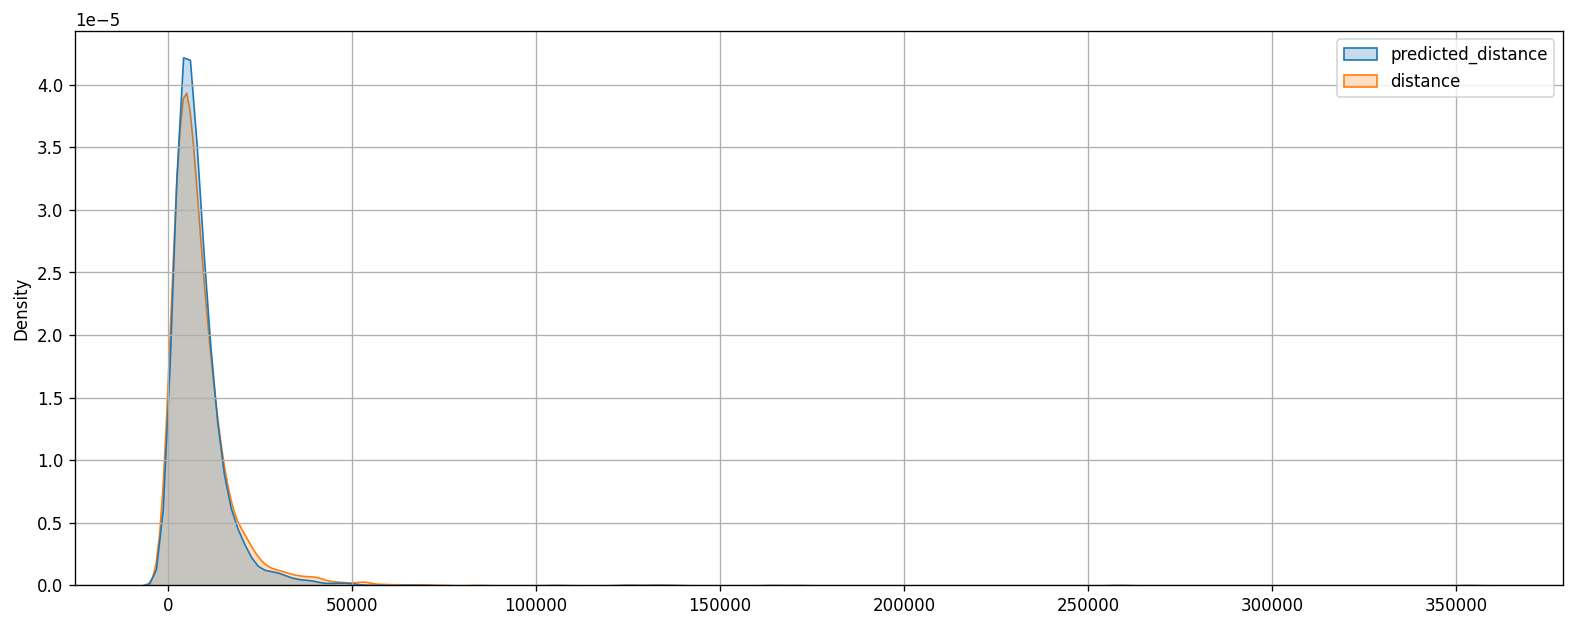

<IPython.core.display.Javascript object>

In [23]:
fig, ax = plt.subplots(figsize=(16, 6), dpi=120)
sns.kdeplot(
    data=upfront_pricing_data_df[["predicted_distance", "distance"]], ax=ax, fill=True
)
plt.grid()
plt.show()

The same goes for distance. the predicted distance typically lays on the lower end.

There's a common theme where the algorithm tends to under-estimate the pricing, distance and duration.

## Problem Impact

How many customers does this deviation impact?

In [24]:
pricing_data_df.shape

(4270, 19)

<IPython.core.display.Javascript object>

Assuming our population consists of 4270 customers.

In [25]:
upfront_pricing_data_df.shape[0] / pricing_data_df.shape[0]

0.6988290398126463

<IPython.core.display.Javascript object>

In [26]:
upfront_pricing_data_df.shape[0]

2984

<IPython.core.display.Javascript object>

Around 70% of the customers have suffered from some form of a deviation between upfront and metered pricing on the app.

In [27]:
upfront_pricing_data_df["upfront_price_deviation_perc"].describe(
    percentiles=[0.25, 0.35, 0.5, 0.55, 0.75, 0.85, 0.9, 0.95, 0.99]
)

count    2984.000000
mean      -17.504548
std        63.270554
min     -1154.732387
25%       -26.976295
35%       -20.225343
50%        -4.335574
55%        -1.633124
75%         4.449203
85%        11.418258
90%        21.674346
95%        45.750281
99%        73.616667
max        97.700427
Name: upfront_price_deviation_perc, dtype: float64

<IPython.core.display.Javascript object>

In [28]:
upfront_pricing_data_df[
    upfront_pricing_data_df["upfront_price_deviation_perc"] < 0
].shape[0] / upfront_pricing_data_df.shape[0]

0.5851206434316354

<IPython.core.display.Javascript object>

Around 60% of the customers see a price higher than the one that is shown upfront.

In [29]:
upfront_pricing_data_df[
    upfront_pricing_data_df["upfront_price_deviation_perc"] < -20
].shape[0] / upfront_pricing_data_df.shape[0]

0.3542225201072386

<IPython.core.display.Javascript object>

Around 35% of the customers get charged more at the end of the journey.

We're going to assume that anyone who created an `overpaid_ride_ticket` and didn't pay more for a ride, did it by accident. 

In [30]:
upfront_pricing_data_df[
    (upfront_pricing_data_df["upfront_price_deviation_perc"] < -20)
]["overpaid_ride_ticket"].value_counts(normalize=True)

0    0.952696
1    0.047304
Name: overpaid_ride_ticket, dtype: float64

<IPython.core.display.Javascript object>

4% of customers who were shown a higher price (i.e. with a deviation of 20%), complained about an overpaid ticket.

## Identifying the source of the deviation

What factor is causing the price to deviate more than usual? When is the deviation occuring and by how much?

In [31]:
upfront_pricing_data_df["abs_upfront_price_deviation_perc"] = abs(
    (
        upfront_pricing_data_df["upfront_price"]
        - upfront_pricing_data_df["metered_price"]
    )
    / upfront_pricing_data_df["upfront_price"]
    * 100
)

/var/folders/s4/n8kktn1x7jn2c6hfpf4y7hch0000gq/T/ipykernel_73208/4229554000.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upfront_pricing_data_df["abs_upfront_price_deviation_perc"] = abs(


<IPython.core.display.Javascript object>

### GPS Confidence

Is the GPS confidence poor which is why we're seeing such a high deviation?

In [32]:
gps_price_abs_deviation_df = (
    upfront_pricing_data_df.groupby(["gps_confidence"])[
        "abs_upfront_price_deviation_perc"
    ]
    .agg(["mean", "count", "median", "std"])
    .reset_index()
).rename(
    columns={
        "mean": "Mean Abs Deviation (%)",
        "median": "Median Abs Deviation (%)",
        "std": "Standard Deviation",
    }
)
gps_price_abs_deviation_df["Coefficient of Variation"] = (
    gps_price_abs_deviation_df["Standard Deviation"]
    / gps_price_abs_deviation_df["Mean Abs Deviation (%)"]
)

<IPython.core.display.Javascript object>

In [33]:
gps_price_abs_deviation_df

,gps_confidence,Mean Abs Deviation (%),count,Median Abs Deviation (%),Standard Deviation,Coefficient of Variation
0,0,95.710549,306,55.415778,130.888029,1.367540
1,1,23.252140,2678,14.151863,35.531035,1.528076


<IPython.core.display.Javascript object>

* There's a significant increase in both the mean and median deviation of pricing when the GPS confidence is poor.
* Could this be a result of the device someone is utilizing?

In [34]:
upfront_pricing_data_df["device_manufacturer"] = (
    upfront_pricing_data_df["device_name"].str.split(" |,|\-|\_").str[0].str.lower()
)
upfront_pricing_data_df["device_manufacturer"] = upfront_pricing_data_df[
    "device_manufacturer"
].apply(lambda x: "iphone" if "iphone" in x else x)
upfront_pricing_data_df["device_manufacturer"] = upfront_pricing_data_df[
    "device_manufacturer"
].apply(lambda x: "tecno" if "tecno" in x else x)

/var/folders/s4/n8kktn1x7jn2c6hfpf4y7hch0000gq/T/ipykernel_73208/3008512248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upfront_pricing_data_df["device_manufacturer"] = (
/var/folders/s4/n8kktn1x7jn2c6hfpf4y7hch0000gq/T/ipykernel_73208/3008512248.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upfront_pricing_data_df["device_manufacturer"] = upfront_pricing_data_df[
/var/folders/s4/n8kktn1x7jn2c6hfpf4y7hch0000gq/T/ipykernel_73208/3008512248.py:7: SettingWithCopyWarning: 
A value is trying to be 

<IPython.core.display.Javascript object>

Which device manufacturer is returning the highest gps confidence error?

In [35]:
gps_low_conf_device_perc_df = pd.merge(
    upfront_pricing_data_df.groupby(["device_manufacturer"])["gps_confidence"]
    .count()
    .reset_index()
    .rename(columns={"gps_confidence": "Num Devices"}),
    upfront_pricing_data_df[upfront_pricing_data_df["gps_confidence"] == 0]
    .groupby(["device_manufacturer"])["gps_confidence"]
    .count()
    .reset_index()
    .rename(columns={"gps_confidence": "Num Devices with 0 GPS conf"}),
    on="device_manufacturer",
    how="left",
).fillna(0)

gps_low_conf_device_perc_df["% 0 GPS conf devices"] = (
    gps_low_conf_device_perc_df["Num Devices with 0 GPS conf"]
    * 100.0
    / gps_low_conf_device_perc_df["Num Devices"]
)

<IPython.core.display.Javascript object>

In [36]:
gps_low_conf_device_perc_df.sort_values(["% 0 GPS conf devices"], ascending=False).head(
    15
)

,device_manufacturer,Num Devices,Num Devices with 0 GPS conf,% 0 GPS conf devices
40,welcome,1,1.0,100.000000
12,foxconn,6,6.0,100.000000
0,alps,4,3.0,75.000000
3,blu,4,3.0,75.000000
13,fujitsu,2,1.0,50.000000
11,fise,2,1.0,50.000000
37,tecno,321,110.0,34.267913
17,htc,9,3.0,33.333333
19,infinix,85,27.0,31.764706
21,itel,43,12.0,27.906977


<IPython.core.display.Javascript object>

In [37]:
gps_low_conf_device_perc_df[
    gps_low_conf_device_perc_df["Num Devices"] >= 10
].sort_values(["% 0 GPS conf devices"], ascending=False).head(15)

,device_manufacturer,Num Devices,Num Devices with 0 GPS conf,% 0 GPS conf devices
37,tecno,321,110.0,34.267913
19,infinix,85,27.0,31.764706
21,itel,43,12.0,27.906977
16,hmd,81,12.0,14.814815
35,sony,35,4.0,11.428571
33,samsung,1162,68.0,5.851979
20,iphone,310,18.0,5.806452
25,lenovo,20,1.0,5.000000
4,bullittgrouplimited,22,1.0,4.545455
43,xiaomi,205,9.0,4.390244


<IPython.core.display.Javascript object>

Brands like `infinix`, `itel`, `tecno` seem to be the culprit here, as they're resulting in a high percentage of device with poor GPS confidence.

### Device Manufacturer

In [38]:
device_price_abs_deviation_df = (
    upfront_pricing_data_df.groupby(["device_manufacturer"])[
        "abs_upfront_price_deviation_perc"
    ]
    .agg(["mean", "count", "median", "std"])
    .reset_index()
).rename(
    columns={
        "mean": "Mean Abs Deviation (%)",
        "median": "Median Abs Deviation (%)",
    }
)

<IPython.core.display.Javascript object>

In [39]:
device_price_abs_deviation_df[device_price_abs_deviation_df["count"] > 10].sort_values(
    "Median Abs Deviation (%)", ascending=False
)

,device_manufacturer,Mean Abs Deviation (%),count,Median Abs Deviation (%),std
21,itel,58.768201,43,41.545000,77.197400
37,tecno,57.171041,321,28.595273,103.281983
19,infinix,42.257589,85,26.457895,53.987941
4,bullittgrouplimited,29.926596,22,24.036885,32.065987
16,hmd,49.270401,81,21.720667,106.658499
25,lenovo,53.792534,20,18.093044,95.164486
18,huawei,26.069487,569,15.277778,48.653991
20,iphone,26.878911,310,15.208034,59.003436
26,lge,26.496665,31,14.961538,44.844454
33,samsung,24.281881,1162,14.100216,35.915936


<IPython.core.display.Javascript object>

In line with the points with from the poor GPS confidence, brands like `infinix`, `itel`, `tecno` also result in a high median deviation and might require additional calibration.

### Date

Is there any particular day that the prices are deviation more often?

In [40]:
upfront_pricing_data_df["ride_date"] = upfront_pricing_data_df["calc_created"].dt.date

/var/folders/s4/n8kktn1x7jn2c6hfpf4y7hch0000gq/T/ipykernel_73208/491300784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upfront_pricing_data_df["ride_date"] = upfront_pricing_data_df["calc_created"].dt.date


<IPython.core.display.Javascript object>

In [41]:
date_price_abs_deviation_df = (
    upfront_pricing_data_df.groupby(["ride_date"])["abs_upfront_price_deviation_perc"]
    .agg(["mean", "count", "median", "std"])
    .reset_index()
).rename(
    columns={
        "mean": "Mean Abs Deviation (%)",
        "ride_date": "Ride Date",
        "median": "Median Abs Deviation (%)",
    }
)
date_price_abs_deviation_df["Coefficient of Variation"] = (
    date_price_abs_deviation_df["std"]
    / date_price_abs_deviation_df["Mean Abs Deviation (%)"]
)
melted_date_price_abs_deviation_df = pd.melt(
    date_price_abs_deviation_df,
    value_vars=["Median Abs Deviation (%)", "Mean Abs Deviation (%)"],
    id_vars="Ride Date",
)

<IPython.core.display.Javascript object>

In [42]:
melted_date_price_abs_deviation_df

,Ride Date,variable,value
0,2020-02-02,Median Abs Deviation (%),21.562500
1,2020-02-03,Median Abs Deviation (%),24.276092
2,2020-02-04,Median Abs Deviation (%),28.591130
3,2020-02-05,Median Abs Deviation (%),15.918367
4,2020-02-06,Median Abs Deviation (%),18.040000
...,...,...,...
77,2020-03-09,Mean Abs Deviation (%),19.307624
78,2020-03-10,Mean Abs Deviation (%),19.534219
79,2020-03-11,Mean Abs Deviation (%),23.195917
80,2020-03-12,Mean Abs Deviation (%),24.496161


<IPython.core.display.Javascript object>

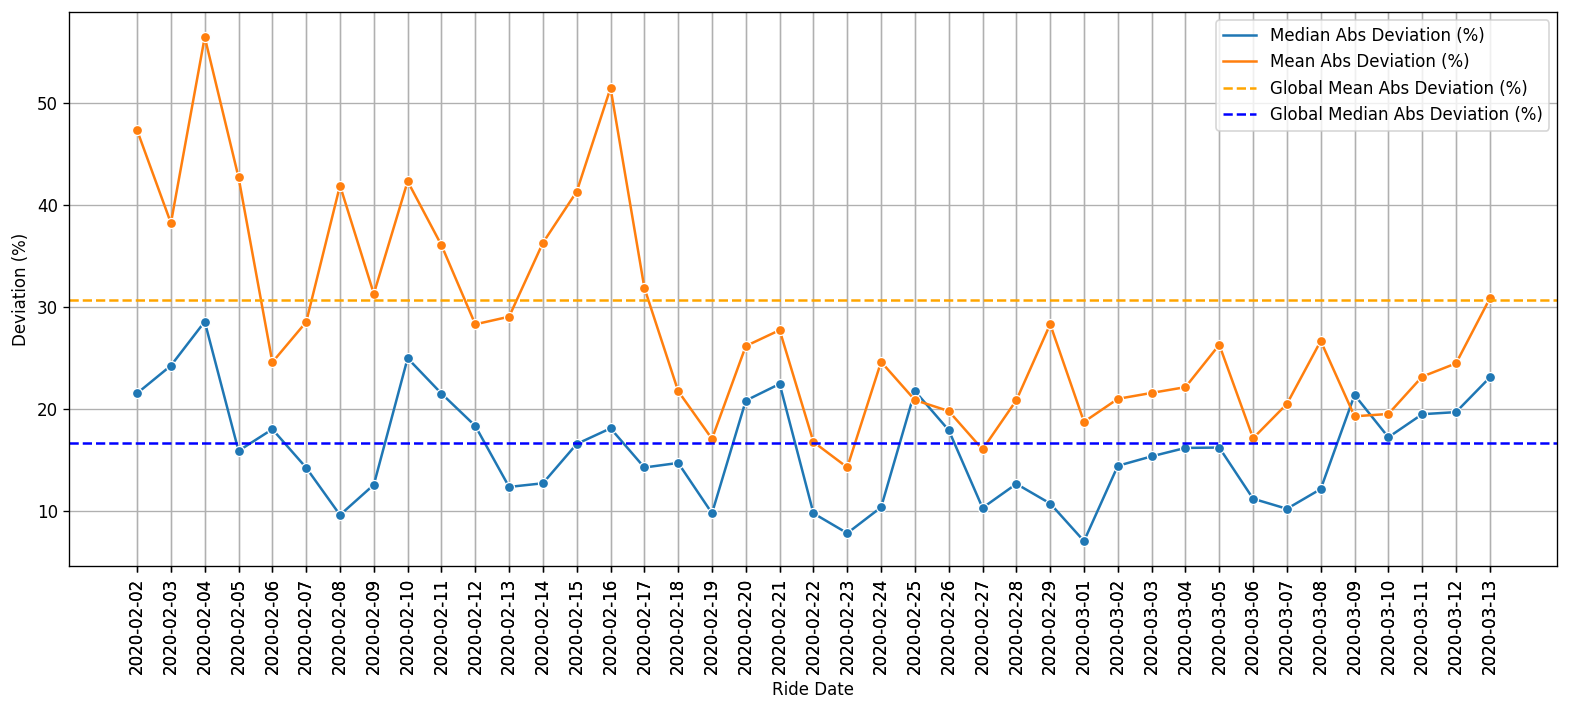

<IPython.core.display.Javascript object>

In [43]:
fig, ax = plt.subplots(figsize=(16, 6), dpi=120)
g = sns.lineplot(
    data=melted_date_price_abs_deviation_df,
    x="Ride Date",
    y="value",
    hue="variable",
    marker="o",
    ax=ax,
)
plt.xticks(rotation=90)
ax.set(xticks=melted_date_price_abs_deviation_df["Ride Date"].values)
plt.ylabel("Deviation (%)")
g.axhline(
    upfront_pricing_data_df["abs_upfront_price_deviation_perc"].mean(),
    linestyle="--",
    color="orange",
    label="Global Mean Abs Deviation (%)",
)
g.axhline(
    upfront_pricing_data_df["abs_upfront_price_deviation_perc"].median(),
    linestyle="--",
    color="blue",
    label="Global Median Abs Deviation (%)",
)
plt.legend()
plt.grid()

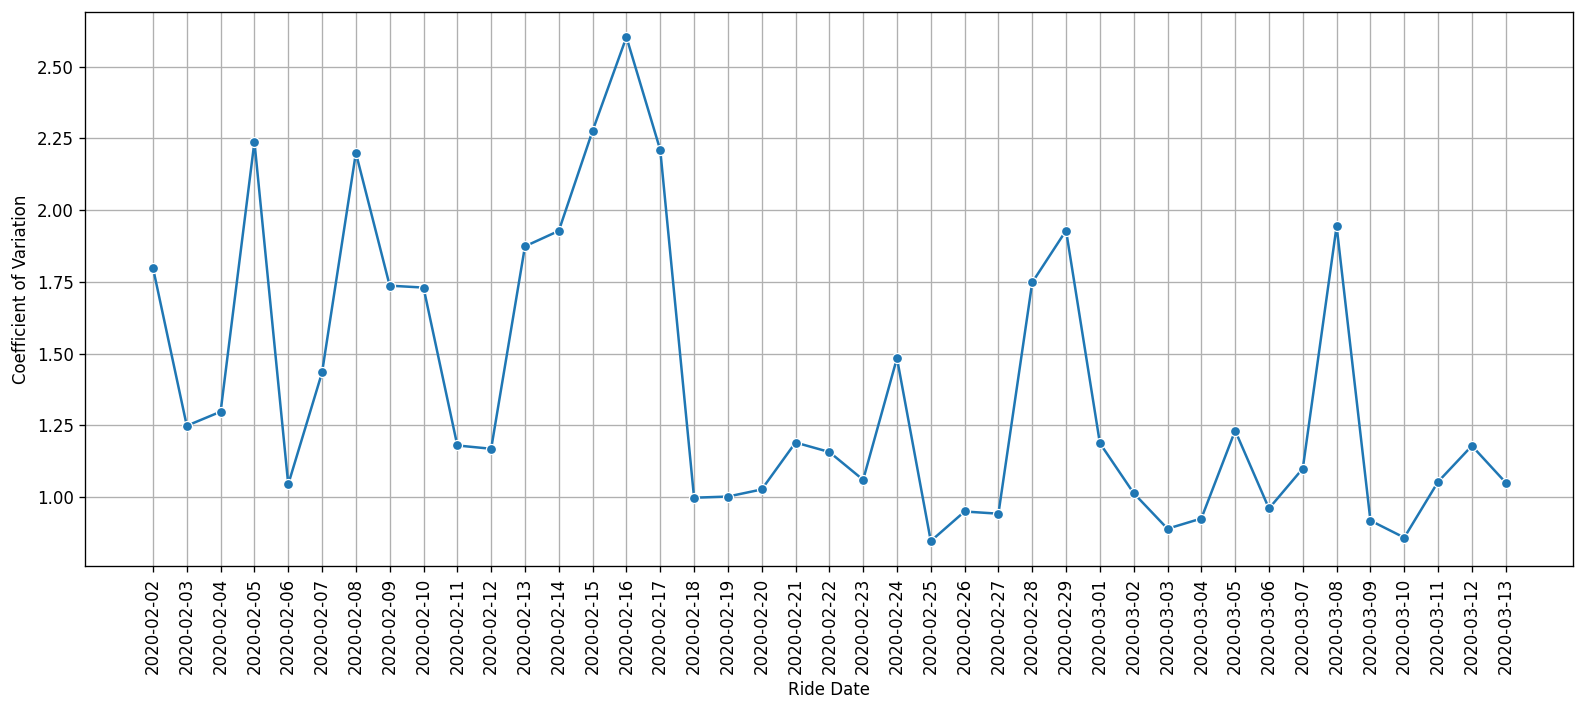

<IPython.core.display.Javascript object>

In [44]:
fig, ax = plt.subplots(figsize=(16, 6), dpi=120)
sns.lineplot(
    data=date_price_abs_deviation_df,
    x="Ride Date",
    y="Coefficient of Variation",
    marker="o",
    ax=ax,
)
plt.xticks(rotation=90)
ax.set(xticks=date_price_abs_deviation_df["Ride Date"].values)
plt.grid()

In [45]:
upfront_pricing_data_df.loc[
    upfront_pricing_data_df["ride_date"]
    == dt.datetime(year=2020, month=2, day=4).date(),
    ["abs_upfront_price_deviation_perc"],
].describe()

,abs_upfront_price_deviation_perc
count,89.000000
mean,56.492610
std,73.295214
min,0.000000
25%,11.042000
50%,28.591130
75%,75.000000
max,386.165250


<IPython.core.display.Javascript object>

* Although the mean deviation is higher on the 16th, the median is still roughly similar to the global median. 
* There is an outlier on the 16th that's resulting in the higher mean price deviation. Furthermore, the coefficient of variation is the highest on that date.
* Date isn't a factor that's directly impacting the upfront price deviation.

In [46]:
upfront_pricing_data_df.loc[
    (
        upfront_pricing_data_df["ride_date"]
        == dt.datetime(year=2020, month=2, day=4).date()
    )
    & (upfront_pricing_data_df["abs_upfront_price_deviation_perc"] >= 300),
].T

,1570,2203
order_id_new,211,280
calc_created,2020-02-04 10:18:37,2020-02-04 16:44:45
metered_price,81937.04,38893.22
upfront_price,18500.0,8000.0
distance,41057,26415
duration,13768,3144
gps_confidence,0,0
entered_by,client,client
dest_change_number,1,1
predicted_distance,14766.0,5187.0


<IPython.core.display.Javascript object>

There's a significant difference in the duration and distance here, which is why we're seeing such a mean deviation.

## Destination Changes

Changing destinations midway through the ride could require the algorithm to re-calculate the journey.

In [47]:
dest_price_abs_deviation_df = (
    upfront_pricing_data_df.groupby(["dest_change_number"])[
        "abs_upfront_price_deviation_perc"
    ]
    .agg(["mean", "count", "median", "std"])
    .reset_index()
).rename(
    columns={
        "mean": "Mean Abs Deviation (%)",
        "median": "Median Abs Deviation (%)",
        "std": "Standard Deviation",
    }
)
dest_price_abs_deviation_df["Coefficient of Variation"] = (
    dest_price_abs_deviation_df["Standard Deviation"]
    / dest_price_abs_deviation_df["Mean Abs Deviation (%)"]
)

<IPython.core.display.Javascript object>

In [48]:
dest_price_abs_deviation_df

,dest_change_number,Mean Abs Deviation (%),count,Median Abs Deviation (%),Standard Deviation,Coefficient of Variation
0,1,29.670394,2873,16.024845,56.495670,1.904109
1,2,36.863870,49,18.873239,44.396102,1.204326
2,3,65.525390,52,36.763728,85.585217,1.306138
3,4,156.289365,6,44.790761,219.323125,1.403314
4,5,2.893103,2,2.893103,0.434017,0.150018
5,7,78.221525,2,78.221525,49.739775,0.635883


<IPython.core.display.Javascript object>

* There's a significant increase in the median deviation above 1 ride changes. 
* However it's difficult to say with confidence that this trend will continue as the number of ride changes increase.
* We can probably show the customer an alert stating that pricing would change drastically with each ride change.

## EU Indicator

In [50]:
eu_price_abs_deviation_df = (
    upfront_pricing_data_df.groupby(["eu_indicator"])[
        "abs_upfront_price_deviation_perc"
    ]
    .agg(["mean", "count", "median", "std"])
    .reset_index()
).rename(
    columns={
        "mean": "Mean Abs Deviation (%)",
        "median": "Median Abs Deviation (%)",
        "std": "Standard Deviation",
    }
)
eu_price_abs_deviation_df["Coefficient of Variation"] = (
    eu_price_abs_deviation_df["Standard Deviation"]
    / eu_price_abs_deviation_df["Mean Abs Deviation (%)"]
)

<IPython.core.display.Javascript object>

In [51]:
eu_price_abs_deviation_df

,eu_indicator,Mean Abs Deviation (%),count,Median Abs Deviation (%),Standard Deviation,Coefficient of Variation
0,0,56.735657,706,25.733732,94.597697,1.667341
1,1,22.608114,2278,13.647450,36.957138,1.634685


<IPython.core.display.Javascript object>

* There is a much higher delta in non-EU countries
* This could be because the road infrastructure is far better in the EU. Frequent road closures, deviation in distances cause prices to increase.
* It could also be due to regulations put in place that do not allow price deviations in the EU.

In [52]:
upfront_pricing_data_df["abs_distance_deviation_perc"] = abs(
    (
        upfront_pricing_data_df["predicted_distance"]
        - upfront_pricing_data_df["distance"]
    )
    / upfront_pricing_data_df["predicted_distance"]
    * 100
)

/var/folders/s4/n8kktn1x7jn2c6hfpf4y7hch0000gq/T/ipykernel_73208/2985416478.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upfront_pricing_data_df["abs_distance_deviation_perc"] = abs(


<IPython.core.display.Javascript object>

In [53]:
eu_distance_abs_deviation_df = (
    upfront_pricing_data_df.groupby(["eu_indicator"])["abs_distance_deviation_perc"]
    .agg(["mean", "count", "median", "std"])
    .reset_index()
).rename(
    columns={
        "mean": "Mean Abs Deviation (%)",
        "median": "Median Abs Deviation (%)",
        "std": "Standard Deviation",
    }
)
eu_distance_abs_deviation_df["Coefficient of Variation"] = (
    eu_distance_abs_deviation_df["Standard Deviation"]
    / eu_distance_abs_deviation_df["Mean Abs Deviation (%)"]
)

<IPython.core.display.Javascript object>

In [54]:
eu_distance_abs_deviation_df

,eu_indicator,Mean Abs Deviation (%),count,Median Abs Deviation (%),Standard Deviation,Coefficient of Variation
0,0,62.515441,706,34.035366,87.730839,1.403347
1,1,30.817081,2278,12.194187,140.684272,4.565139


<IPython.core.display.Javascript object>

Since deviation in distances and deviation in prices is correlated, it's evident that distances deviate more likely in non-EU countries as opposed to EU ones.

## App version

Is there any particular app version that's buggy?

Although pricing is calculated on the backend, is there something inherently wrong with a way a certain app version extracts location or duration information?

In [55]:
ride_appv_price_abs_deviation_df = (
    upfront_pricing_data_df.groupby(["rider_app_version"])[
        "abs_upfront_price_deviation_perc"
    ]
    .agg(["mean", "count", "median", "std"])
    .reset_index()
).rename(
    columns={
        "mean": "Mean Abs Deviation (%)",
        "median": "Median Abs Deviation (%)",
        "std": "Standard Deviation",
    }
)
ride_appv_price_abs_deviation_df["Coefficient of Variation"] = (
    ride_appv_price_abs_deviation_df["Standard Deviation"]
    / ride_appv_price_abs_deviation_df["Mean Abs Deviation (%)"]
)

<IPython.core.display.Javascript object>

In [56]:
ride_appv_price_abs_deviation_df[
    ride_appv_price_abs_deviation_df["count"] > 10
].sort_values(by=["Median Abs Deviation (%)"], ascending=False).head(25)

,rider_app_version,Mean Abs Deviation (%),count,Median Abs Deviation (%),Standard Deviation,Coefficient of Variation
56,CA.5.47,34.609615,50,27.749529,37.221572,1.075469
87,CI.4.11,28.045800,15,23.750000,27.973147,0.997410
34,CA.5.08,35.812453,13,22.959116,39.579469,1.105187
49,CA.5.38,29.187596,27,22.333333,30.941768,1.060100
81,CI.4.04,23.642331,11,22.307692,17.244367,0.729385
47,CA.5.36,42.568204,95,22.156863,65.684249,1.543035
45,CA.5.32,37.592955,43,21.428571,82.231247,2.187411
35,CA.5.13,35.103528,11,21.388889,27.500050,0.783398
32,CA.5.04,40.726749,15,21.000000,59.132441,1.451931
90,CI.4.14,35.100988,96,19.532794,64.834100,1.847073


<IPython.core.display.Javascript object>

* It seems like certain app versions like `CA.5.47` are producing higher Median abs deviation than others and might need to be looked into.
* Since app versions depend on adoption, we can check to see the percentage of rides on an app version with at least 20% deviation.

In [57]:
ride_appv_price_deviation_perc_df = (
    pd.merge(
        upfront_pricing_data_df.groupby(["rider_app_version"])["order_id_new"]
        .count()
        .reset_index(),
        upfront_pricing_data_df[
            upfront_pricing_data_df["abs_upfront_price_deviation_perc"] > 20
        ]
        .groupby(["rider_app_version"])["order_id_new"]
        .count()
        .reset_index(),
        on=["rider_app_version"],
        how="left",
    )
    .fillna(0)
    .rename(
        columns={
            "order_id_new_x": "num_rides",
            "order_id_new_y": "num_rides_with_20_perc_deviation",
        }
    )
)

<IPython.core.display.Javascript object>

In [58]:
ride_appv_price_deviation_perc_df["perc_rides_with_20_perc_deviation"] = (
    ride_appv_price_deviation_perc_df["num_rides_with_20_perc_deviation"]
    * 100
    / ride_appv_price_deviation_perc_df["num_rides"]
)

<IPython.core.display.Javascript object>

In [59]:
ride_appv_price_deviation_perc_df[
    ride_appv_price_deviation_perc_df["num_rides"] > 10
].sort_values(by=["perc_rides_with_20_perc_deviation"], ascending=False)

,rider_app_version,num_rides,num_rides_with_20_perc_deviation,perc_rides_with_20_perc_deviation
35,CA.5.13,11,8.0,72.727273
87,CI.4.11,15,10.0,66.666667
56,CA.5.47,50,30.0,60.000000
49,CA.5.38,27,16.0,59.259259
81,CI.4.04,11,6.0,54.545455
34,CA.5.08,13,7.0,53.846154
32,CA.5.04,15,8.0,53.333333
47,CA.5.36,95,50.0,52.631579
45,CA.5.32,43,22.0,51.162791
40,CA.5.23,18,9.0,50.000000


<IPython.core.display.Javascript object>

Similar to the insight above, app versions like `CA.5.47` are producing a high number of rides with errors.

## 0 Distances

In [60]:
upfront_pricing_data_df.loc[
    upfront_pricing_data_df["distance"] == 0, "abs_upfront_price_deviation_perc"
].describe()

count    35.000000
mean     43.990430
std      27.875741
min       0.000000
25%      25.000000
50%      53.488372
75%      63.192469
max      78.947368
Name: abs_upfront_price_deviation_perc, dtype: float64

<IPython.core.display.Javascript object>

In [61]:
upfront_pricing_data_df.loc[
    upfront_pricing_data_df["duration"] == 0, ["distance", "duration"]
]

,distance,duration
88,0,0
220,0,0
508,0,0
509,0,0
633,0,0
747,0,0
1325,0,0
1624,0,0
1716,0,0
1864,0,0


<IPython.core.display.Javascript object>

In [62]:
upfront_pricing_data_df.loc[
    upfront_pricing_data_df["duration"] == 0, ["distance", "duration"]
].shape

(18, 2)

<IPython.core.display.Javascript object>